# Track 4: Collisionless N-body simulations - Project 1: Spiral Galaxy Mergers
-------------------------------------------------------------------------------------------------------------------------------------------

## 0 Contents

[1 Introduction](#1-Introduction) 
- [1.1 Short introduction to the N-body problem](#1.1-Short-introduction-to-the-N-body-problem) 
- [1.2 The difference between collisional and collisionless systems](#1.2-The-difference-between-collisional-and-collisionless-systems)
- [1.3 The force estimate in collisionless simulations based on tree algorithms](#1.3-The-force-estimate-in-collisionless-simulations-based-on-tree-algorithms)
- [1.4 Fireworks package](#1.4-Fireworks-package) 
  
[2 Data and methods](#2-Data-and-methods) 
- [2.1 Data and methods in common](#2.1-Data-and-methods-in-common)
- [2.2 Simulation set-ups](#2.2-Simulation-set-ups)
  
[3 Result and discussion](#3-Result-and-discussion) 
- [3.1 The stability of a disc representation](#3.1-The-stability-of-a-disc-representation)
- [3.2 The result of a two-galaxy encounter](#3.2-The-result-of-a-two-galaxy-encounter)
- [3.3 The encounter of two counter-rotating galaxies](#3.3-The-encounter-of-two-counter-rotating-galaxies)
  
[4 Conclusion and possible future work](#4-Conclusion-and-possible-future-work) \
[5 Reference](#5-Reference)

-------------------------------------------------------------------------------------------------------------------------------------------

## 1 Introduction

### 1.1 Short introduction to the N-body problem

**N-body problem** is an initial value problem of predicting the motions of N elements in a system resulting from interacting forces of the other elements. In astrophysics, the elements can be many things, such as stars, gas particles, and dark matter, depending on the N-body systems, while the interacting forces are gravitational. Since the speed of the elements in astrophysical systems is much slower than the speed of light, Newton's treatment is enough to consider most astrophysical cases. In general, to solve this problem i.e. to obtain the position of each member in the system ($x_i$), we need to solve 3xN 2nd-order ordinary differential equations (ODEs) for positions in 3-dimensional coordinates: 
$${d^2x_i \over dt^2}= - G  \sum_{j=1,j \ne i}^N m_j {x_i-x_j \over \left\lvert{x_i-x_j}\right\rvert^3}, $$

which can be split into 6xN 1st-order ODEs to make them easier to solve by coding:

\begin{cases}
    {dv_i \over dt}= - G  \sum_{j=1,j \ne i}^N m_j {x_i-x_j \over \left\lvert{x_i-x_j}\right\rvert^3} \\
    {dx_i \over dt}=v_i
\end{cases}

Unfortunately, there is no analytic solution for a system of ODE with $N \ge 3$. Numerical N-body simulations are used instead to fix this problem.

The numerical complexity of integrating ODEs directly is $O(N^2)$. However, since N is large in many cases, it takes a long time to integrate ODEs directly. Thus, there are many efforts to reduce this complexity by thinking of new algorithms such as in [1.3 The force estimate in collisionless simulations based on tree algorithms](#1.3-The-force-estimate-in-collisionless-simulations-based-on-tree-algorithms) which will be used in this project. 

### 1.2 The difference between collisional and collisionless systems

The main difference we use to distinguish between collisional and collisionless systems is that we can neglect a strong encounter between 2 close particles in collisionless systems while we cannot do so in collisional systems. The strong encounter for star systems (and also for this project because we use stars as tracers for the N-body simulation) can be considered following *Figure 1*, where the test star passes the field star at a relative velocity $v$ along the horizontal axis with the closest distance between the two stars of $b$ called *impact parameter*. If there is no strong encounter, the test mass will continue moving straight along the horizontal axis. On the contrary, if there is an encounter, the trajectory will be deviated towards the position of the field star.
<div style="text-align:center">
    <img src="./Final_project_data/Images_in_report/Strong_encounter.png" alt="Image Description" style="width:500px;"/>
    <p style="text-align:center"><em>Figure 1: The scheme of a strong encounter in a stellar system (Credit: Lecture 1 page 33) </em></p>
</div>

One way to classify the type of systems is to compare the lifetime of the system ($t_{life}$) and the time to have 1 strong encounter, which is called *relaxation time ($t_{relax}$)*. $t_{relax}$ is derived by considering the force on the test star exerted by the field star and estimating the order of magnitude of the velocity change ($\delta v$) by assuming a small perturbation of the velocity (${\delta v \over v} \ll 1$). 
$$t_{relax} \sim {0.1NR \over vlnN},$$
where N is the number of members in the system, $v$ is the typical orbital speed the members use to orbit around the system's center, and R is the system's radius.

If $t_{life} \ll t_{relax}$, there is a low probability of having a strong collision during the system's lifetime, meaning that it is a **collisionless system**. While in the case that $t_{life} \gtrsim t_{relax}$, there will be a high chance to have strong collisions in the system, which we call this system a **collisional system**. The main properties of the 2 types of systems are summarized here:

**Collisional systems**
* Particle-particle interactions are significant in affecting particle motions $\rightarrow$ Need to estimate direct force
* Systems tend to have smooth structures and roundish shapes
* e.g., open and globular clusters
  
**Collisionless systems**
* Stars' trajectories are the result of overall matter distribution $\rightarrow$ Can reduce simulation complexity by treating the systems as fluids
* Systems have structures because $t_{relax}$ is too long to smooth-out structures
* e.g., galaxies


To classify the type of spiral galaxies that we are studying in this project, let's consider our Milky Way (MW) galaxy as an example. MW comprises $\sim 10^{11}$ stars with a radius of $\sim 10^{20}$ m (from the galactic center to the Sun) and (relative) orbital speed of stars of $\sim 10^{4}$ m/s. Thus $t_{relax} \sim 10^{17}$ yr. The MW's lifetime can be considered using the age of the Universe of $\sim 10^{10}$ yr by assuming that the Universe expands with the constant Hubble rate from the Big Bang until now. Then, $t_{relax} \gg t_{life}$ for spiral galaxies, indicating that they are collisionless systems.

### 1.3 The force estimate in collisionless simulations based on tree algorithms

To speed up the force estimator by reducing the number of operations in coding, instead of estimating the forces of all faraway particles directly, we estimate the force due to a group of particles as a whole, called *super-particle*. This kind of force estimators works based on the so-called *tree algorithm*. Two interesting tree algorithms will be described here:

* **Barnes & Hut algorithm:** This follows the clustering theory *Oct-Tree* algorithm proposed by Barnes & Hut (1986). Basically, it splits the system in 3-dimensional space until there is only one particle in each branch, which is the box in which each particle resides. To estimate force, it calculates the direct force between nearby particles, while the force between faraway particles is estimated by using the Center of Mass (CoM) of each branch (super-particle). To decide whether particles are nearby or far away from the considered branch, it uses the *opening angle* $\theta = {S_{branch} \over D_{i,branch}}$, where $S_{branch}$ is the dimension of the considered tree branch and $D_{i,branch}$ is the distance between the particle and the branch CoM. If $\theta < \theta_0$ (typically $\theta_0 = 0.5$), the branch is distant enough and we can calculate the force due to that whole branch (CoM). If $\theta > \theta_0$, the branch is too close, we need to move to its sub-branches until $\theta > \theta_0$, then we  can estimate force. Now, the time complexity of the estimator is $O(NlnN)$, which is much faster than the direct force estimator with the time complexity of $O(N^2)$, as shown in *Figure 2* in [2 Data and methods](#2-Data-and-methods). Note that the O(lnN) term of this time complexity is from the average tree depth instead of O(N) like in the direct estimator since we no longer need to compute individual forces from every single particle.
* **Dehnen algorithm:** In the case of Barnes & Hut algorithm, it uses monopole force approximation. We can write the exact potential (which can be turned to force) due to all particles in the branch B on a point at distance r from the branch B CoM:  $$\Phi_B(\vec{r})=\sum_i \Phi(\vec{r}-\vec{r}_i)={M \over |r|}+{D \over |r|^3}+{Q \over |r|^5}+...,$$
  where the 1st, 2nd, and 3rd terms on the right-hand side are monopole, dipole, and quadrupole terms, respectively.
  Notice that for a distant object with a large r, only a monopole term is enough to estimate, which is the case of the Barnes & Hut algorithm.
  
This work uses the *pyfalcon* force estimator, available in fireworks.nbodylib.dynamics and based on the Dehnen tree algorithm.

### 1.4 Fireworks package

**Fireworks** is a Python package containing useful tools for N-body simulations, available at https://gitlab.com/iogiul/pod_compastro23. It is a learning tool for master's degree students in the Computational Astrophysics (2023/2024) class at the University of Padua. The package itself is not complete yet; it is waiting for the students in the class to complement it. 

There are 3 submodules in the package: version, ic, and particles.
* **version**: tells the version of the package in MAJOR.MINOR:PATCH format.
* **ic**: contains functions to generate an initial condition (IC) of an N-body system, and then the IC will be returned as an instance of the class *Particles*.
* **particles**: contains the class *Particles*, storing all information of particles in the N-body system.
 
Furthermore, there is the nbodylib subpackage, which contains the modules dynamics, integrators, nunits, potential, and timesteps used for running N-body simulations.
* **dynamics**: contains functions to estimate acceleration using direct and other algorithms.
* **integrators**: contains integrators to integrate the ODE of the N-body problem at each time step.
* **nunits**: for converting the data between nbody and physical units under the user's decision.
* **potentials**: contains the functions to estimate acceleration from smooth potential for collisionless systems.
* **timesteps**: provides adaptive timesteps (if needed).

In addition, it also provides documents explaining and giving examples of how to use these functions in the package, available at https://ca23-fireworks.readthedocs.io/en/latest/api/_autosummary/fireworks.html#module-fireworks by using *sphinx* to create the documents. As well as the test function allows users to check the correction of the already available codes and the newly developed codes (by users) by using *pytest*.

**Fireworks implementation** starts from generating the IC of the N-body particles stored in the *Particles* class. Then, forces exerted on the particles are estimated using functions in the submodules *dynamics* or *potentials* depending on the system type (collisional or collisionless). Finally, integrators in the submodule *integrators* will integrate the *Particles* properties iteratively with the timestep provided by users or computed by the *timestep* submodule until the final integration time.

In this work, we use the already available submodules *ic*, *particles*, *dynamics*, and *integrators*, as well as create new functions in *Final_project_function.py*, which is available in the same directory of this notebook, and we will describe further in the next section.

-------------------------------------------------------------------------------------------------------------------------------------------

## 2 Data and methods
In this section, we will describe the data, methods, and tools used in general (section 2.1) and the simulation set-up used in each subsection (section 2.2), considering the results we will present in [3 Result and discussion](#3-Result-and-discussion).

### 2.1 Data and methods in common

#### -- 2.1.1 A simplified N-body model of a disc galaxy

In reality, disc galaxies comprise various components, e.g., stars, gas particles, and interstellar dust. In this work, we use stars as tracers and a simplified N-body model of a disc galaxy. The simplified model comprises a central object with all mass distribution of the galaxy, as well as many massless stars in an extremely thin disc (z=0). The positions of the stellar tracers are sampled based on exponential 2D disc distribution. In contrast, their velocities are sampled based on the Plummer profile and set in circular orbits. These ICs are provided in *Nbody_disc.csv*, generated by *Generated_Nbody_disc.py*, which the steps in brief to generate them will be provided as follows:
1) Draws radius sampling in cylindrical coordinates ($R_{cyl}$) from the cumulative density function (cdf) of an exponential 2D probability density function (pdf) by using the inverse sampling method.
2) For position,
   * draws positions in cylindrical coordinates ($R_{cyl}$,$\phi$,z): $R_{cyl}$ distribution from 1., uniform distribution of $\phi$ from 0 to 2$\pi$, and z=0 since particles are in the disc plane;
   * converts the positions in cylindrical coordinates to Cartesian coordinates by using the formulae below:
\begin{cases}
    x = R_{cyl}cos\phi  \\
    y = R_{cyl}sin\phi \\
    z = 0
\end{cases}
3) For velocity,
   * uses $R_{cyl}$ sampling from 1. to draw the azimuthal rotational velocity ($v_{\phi}$) in cylindrical coordinates of each star at its radius $R_{cyl}$ in the disc based on the Plummer profile: $$v_{\phi}(R_{cyl})=\sqrt{{M_{plummer}(R_{cyl})} \over {R_{cyl}}}; M_{plummer}(R_{cyl}) = M_{tot} {R_{cyl}^3 \over {(R_{cyl}^2+a^2)}^{3/2}}$$
where  $M_{tot}$ is total mass of the galaxy, $M_{plummer}(R_{cyl})$ is the cumulative mass at radius $R_{cyl}$, and a is the Plummer scale length or softening;
   * converts the velocities in cylindrical coordinates to Cartesian coordinates by using the formulae below:
\begin{cases}
    v_x = -v_{\phi}sin\phi  \\
    v_y = v_{\phi}cos\phi \\
    v_z = 0 
\end{cases}
$v_z$=0 because there are no vertical motions here.

Note that the input parameters used to generate the IC are total number of particles (N) = $10^5$, total mass of the galaxy ($M_{tot}$) = 1 [Nbody], scale length of the exponential disc = 3 [Nbody], mass of disc tracers = $10^{-11}$ [Nbody], Plummer scale length (a) = 5, minimum radius of the disc = 0.1 [Nbody], and maximum radius of the disc = 30 [Nbody]. Moreover, throughout the simulations and plots in this work, we will use the N-body unit to reduce bugs and errors that might occur in coding. 

Due to our computer limitation, we cannot use all the stars available in *Nbody_disc.csv* ($N=10^5$). Thus, we exploit the running time of each estimator as a function of the used number of particles and its theoretical expectation plot from Assignment 2, as shown in *Figure 2*. From the plot, we found that if we have 8 hours (28800 seconds) for running the code to evolve an N-body system with 100000 time steps, we need 28800/100000 ≈ 0.3 [sec] for each integrating step to run. Therefore, by using *pyfalcon* as an estimator, the
realistic maximum number of particles is $10^4$, and we will use this number for all following simulations.
<div style="text-align:center">
    <img src="./plot_AS2E/AS2E_Npar-vs-time.png" alt="Image Description" style="width:600px;"/>
    <p style="text-align:center"><em>Figure 2: Running time of each estimator as a function of the used number of particles
and its theoretical expectation.</em></p>
</div>

#### -- 2.1.2 *pyfalcon* as the force estimator and *Leapfrog* as the integrator
- **Pyfalcon** is used to estimate acceleration in this project because it is fast and appropriate to collisionless systems, as described in [1.3 The force estimate in collisionless simulations based on tree algorithms](#1.3-The-force-estimate-in-collisionless-simulations-based-on-tree-algorithms). This estimator is a wrapper available in *fireworks.nbodylib.dynamics.acceleration_pyfalcon*. It needs only two inputs: *Particle* instance and softening. *Particle* instance is generated by the *fireworks.ic* method, depending on the science we are interested in, while the softening Plummer scale length of 5 for the estimator is used, which is the same as we used to generate the IC.

- We use **Leapfrog** to integrate the system at different times. Even though it is a 2nd order integrator, its time reversible and symplectic properties make it have a good balance between performance (stability) and accuracy. Its integrating scheme follows the below equations:
  \begin{cases}
    \vec{r}_{i+1}=\vec{r}_{i}+\vec{v}_{i}h+{1 \over 2}\vec{a}_{i}h^2 \\
    \vec{a}_{i+1}=f(\vec{r}_{i+1}) \\
    \vec{v}_{i+1}=\vec{v}_{i}+{1 \over 2}(\vec{a}_{i}+\vec{a}_{i+1})h
\end{cases}
where $\vec{r}_{i}$, $\vec{v}_{i}$, $\vec{a}_{i}$ are the position, velocity, and acceleration of the considered particle at the current time, which we already knew. $\vec{r}_{i+1}$, $\vec{v}_{i+1}$, $\vec{a}_{i+1}$ are the position, velocity, and acceleration of the considered particle at the next time we want to know. And h is timestep.

#### -- 2.1.3 Coordinate Conversion

After the N-body system has evolved for a certain time, we aim to inspect the simulation results. Before plotting the results, there are several coordinate set-ups we need to work on:

1. Rescale positions and velocities of stars \
After a certain time, the position of each star was changed in 3-dimensional spatial coordinates. Thus, to measure their relative position and velocity and convert them into cylindrical coordinates later, we need to rescale the position and velocity values by subtracting the values with the values of the central mass. This step can be done using the function *rescale_system* in *Final_project_function.py*.

2. Convert velocities in Cartesian coordinates ($v_{x}$, $v_{y}$, and $v_{z}$) to azimuthal velocity ($v_{\phi}$) in cylindrical coordinates $v_{\phi}$ is important in plotting rotation curves. To do this work, we can simply apply the system of equations below, which can be done by using the function *vphi_compute* in *Final_project_function.py*.
\begin{cases}
    v_{\phi} = -v_{x}sin\phi + v_{y}cos\phi  \\
    \phi = tan^{-1}(y/x) \\
\end{cases}

3. Convert velocities in cartesian coordinates ($v_{x}$, $v_{y}$, and $v_{z}$) to radial velocity ($v_{R}$) in cylindrical coordinates using the system of equations below and can be done by using the function *vR_compute* in *Final_project_function.py*.
\begin{cases}
    v_{R} = v_{x}cos\phi + v_{y}sin\phi  \\
    \phi = tan^{-1}(y/x) \\
\end{cases}

#### -- 2.1.4 Rotation curves and Surface density profile
Now we give the details of the plots we will use to inspect our simulation results.
- **Rotation curve** shows the relation of the azimuthal velocity ($v_{\phi}$) as a function of the cylindrical radius ($R_{cyl}$) of the particles in a system. To prepare the quantities used in plotting this relation, we use the functions *compute_vphi_vs_R_simple_1galaxy* and *compute_vphi_vs_R_simple_2galaxies* in *Final_project_function.py*. Basically, these functions read in position and velocity in Cartesian coordinates (x, y, z, $v_{x}$, $v_{y}$, and $v_{z}$), then rescale them with respective to the system center and convert them to values in cylindrical coordinates ($R_{cyl} = \sqrt{x^2+y^2}$ and $v_{\phi}$). Additional to azimuthal velocity ($v_{\phi}$), we inspect radial velocity ($v_{R}$) and vertical velocity ($v_{z}$).


- **Surface density profile** shows the amount of mass in the area ($\Sigma$) as a function of the cylindrical ring ($R_{cyl}$). To estimate it, we use the functions *compute_surface_density_1galaxy* and *compute_surface_density_2galaxies* in *Final_project_function.py* which perform following these below steps:
  1) Bins the particles on the cylindrical radius $R_{cyl} = \sqrt{x^2+y^2}$;
  2) Sums all masses of particles to obtain $M_{tot,ring}$;
  3) Computes area of the ring $A_{ring} = \pi(R_{outer}^2-R_{inner}^2)$, where $R_{outer}$ and $R_{inner}$ are the border of the considered bin;
  4) Calculates $\Sigma = M_{tot,ring}/A_{ring}$.

#### -- 2.1.5 Video creation
Apart from the resulting plots, we create the videos of the [3.2 The result of a two-galaxy encounter](#3.2-The-result-of-a-two-galaxy-encounter) and [3.3 The encounter of two counter-rotating galaxies](#3.3-The-encounter-of-two-counter-rotating-galaxies) simulations by creating the arrays of plots using *./create_images_for_video.py* (running on the Docker) and then making simulation videos from the arrays using *./Final_project_data/video_creation.py* (running on our personal computer). That produces *./Final_project_data/3-2_video.mp4* and *./Final_project_data/3-3_video.mp4*.

### 2.2 Simulation set-ups

#### --- 2.2.1 Simulation set-up for [3.1 The stability of a disc representation](#3.1-The-stability-of-a-disc-representation)
- **IC:** We simply read in the IC of $10^4$ stars of the disc representation from *Nbody_disc.csv* by using the function *ic_1galaxy* in *firework.ic*.
- **Simulation time:**  We simulate the system with the simulation time of the characteristic time of the galaxy $t_{char} = 2\pi R/v_{\phi}$, which is the average value of time that of stars in the galaxy used to complete an orbit around the center.
- **Number of timesteps:** $10^3$

#### --- 2.2.2 Simulation set-up for [3.2 The result of a two-galaxy encounter](#3.2-The-result-of-a-two-galaxy-encounter)
- **IC:** We use the function *ic_2galaxies* in *firework.ic* to read in the IC of $5 \times 10^3$ for each galaxy (so, $10^4$ in total). To make it possible to have interaction between the two galaxies, the positions and velocities of particles of *Galaxy 2* are shifted with $\vec{x}_{2,CoM}$=(40,20,0) and $\vec{v}_{2,CoM}$=(-0.2,0,0) with respective to *Galaxy 1* with $\vec{x}_{1,CoM}$=(0,0,0) and $\vec{v}_{1,CoM}$=(0,0,0).
- **Simulation time:** 210 [Nbody] as suggested in the project instruction
- **Number of timesteps:** $10^3$

#### --- 2.2.3 Simulation set-up for [3.3 The encounter of two counter-rotating galaxies](#3.3-The-encounter-of-two-counter-rotating-galaxies)
- **IC:** We use the function *ic_2galaxies_counter_rotating* in *firework.ic* to read in the IC. The number of particles and the step of shifting the position and velocity of particles are the same as the previous simulation. In addition, we multiply -1 to the velocities of all particles of *Galaxy 2* before shifting with $\vec{v}_{2,CoM}$=(-0.2,0,0) to make it have a counter-rotating orbit respective to *Galaxy 1*.
- **Simulation time:** 210 [Nbody] as suggested in the project instruction
- **Number of timesteps:** $10^3$

-------------------------------------------------------------------------------------------------------------------------------------------

## 3 Result and discussion

**Note:** This notebook is REALLY messy due to many codes and plots; my apologies. To make it easier to find the explanation of each result, I suggest searching with the keyword *Result and discussion:*.

#### Import libraries and set paths

In [1]:
import numpy as np
import fireworks.ic as fic
import matplotlib.pyplot as plt
%matplotlib inline

path_plot='./Final_project_data/Plots_results/'

In [2]:
from importlib import reload
import Final_project_function as H
reload(H)

<module 'Final_project_function' from '/ca23/ext_volume/Herschel/Final_project_function.py'>

### 3.1 The stability of a disc representation

In this section, we aim to inspect the stability of a disc representation by running a simulation of one isolated disc galaxy for a certain characteristic time ($t_{char}$) = 153.7 [Nbody] as described in section 2. After that, we plot the disc's velocity curve and surface density profile at initial time = 0 and final time = $t_{char}$ to see how they change over time.

In [3]:
### Generate IC
N=int(1e4)
particles=fic.ic_1galaxy(N)

### Compute the characteristic time of particles used to complete an orbit: 2*np.pi*R/vphi -> avg
pos_arr = particles.pos
vel_arr = particles.vel
pos_re_arr,vel_re_arr=H.rescale_system(pos_arr,vel_arr)
x,y,vx,vy,phi,vphi=H.vphi_compute(pos_re_arr,vel_re_arr)
R=np.sqrt(x**2+y**2)
t_charac_arr=2.*np.pi*R/vphi
t_charac=np.nanmean(t_charac_arr)
print('The characteristic time is:',t_charac)

### Simulation
ti = 0.
tf = t_charac
nstep=int(1e3)
mass_arr,pos_dict,vel_dict=H.sim_galaxy(particles,tf,nstep) #simulaton

/tmp/ipykernel_28/2239349374.py:11: RuntimeWarning: invalid value encountered in divide
  t_charac_arr=2.*np.pi*R/vphi


The characteristic time is: 153.69520296344064


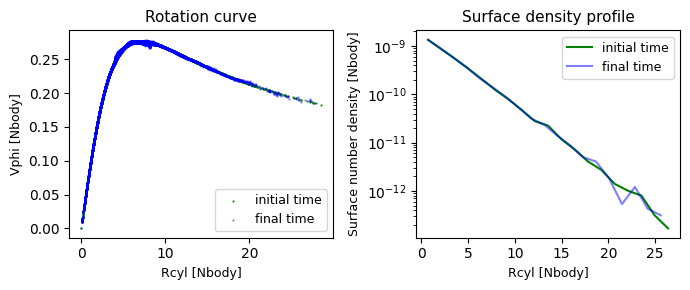

In [4]:
tstep=tf/nstep
t_arr=np.arange(ti+tstep, tf+tstep, tstep)
t_display=np.linspace(ti, tf, num=5, endpoint=True)
idx_display=np.linspace(0, nstep, num=5, endpoint=True)
idx_display=idx_display.astype(int)
key_pos_display=['pos_'+str(idx) for idx in idx_display]
key_vel_display=['vel_'+str(idx) for idx in idx_display]
R_i,vphi_i=H.compute_vphi_vs_R_simple_1galaxy(pos_dict, key_pos_display[0], vel_dict, key_vel_display[0])
R_f,vphi_f=H.compute_vphi_vs_R_simple_1galaxy(pos_dict, key_pos_display[-1], vel_dict, key_vel_display[-1])
Rmid_i,sigma_i=H.compute_surface_density_1galaxy(mass_arr, pos_dict, key_pos_display[0], vel_dict, key_vel_display[0], bins=20)
Rmid_f,sigma_f=H.compute_surface_density_1galaxy(mass_arr, pos_dict, key_pos_display[-1], vel_dict, key_vel_display[-1], bins=20)

### Plot the result summary
fig, axs = plt.subplots(1,2, figsize=(7,3), facecolor='w', edgecolor='k')#,sharey=True
fig.subplots_adjust(wspace=0.35)
axs[0].scatter(R_i,vphi_i,s=0.3,c='g',label='initial time')
axs[0].scatter(R_f,vphi_f,s=0.3,c='b',alpha=0.5,label='final time')
axs[0].legend(fontsize=9)
axs[0].set_ylabel('Vphi [Nbody]',fontsize=9)
axs[0].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[0].set_title('Rotation curve',fontsize=11)
axs[1].plot(Rmid_i,sigma_i,c='g',linewidth=1.5,label='initial time')
axs[1].plot(Rmid_f,sigma_f,c='b',alpha=0.5,linewidth=1.5,label='final time')
axs[1].set_yscale('log')
axs[1].legend(fontsize=9)
axs[1].set_ylabel('Surface number density [Nbody]',fontsize=9)
axs[1].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[1].set_title('Surface density profile',fontsize=11)
plt.tight_layout()
plt.savefig(path_plot+'3-1_1-summary_stability.png', format="png",dpi=300)
plt.show()

*Result and discussion:* \
According to the rotation curve and surface density profile, both remain the same after $t_{char}$, indicating the galaxy is stable and can keep its material (stars in this case) bound for a certain time when there is no interaction with another galaxy. Thus, from now on, the results of the interacting systems we will study are dominated by the interaction itself, not by the instability of a single system.

### 3.2 The result of a two-galaxy encounter

**Idea of how this simple model works (gravitational tides):**
1) Due to the significant difference between the masses of the point-mass at the galactic center (GC) and massless tracers orbiting around it, all motions you will see later (dominantly) result from the gravitational potential due to the point-mass at GC.
2) When two galaxies collide, the massless particles feel the net gravitational potential from the two point-masses at their GCs which are getting closer to each other (and getting away after passing). The materials inside the galaxies undergo deforming effects and re-arrange their components. That creates tidal structures like bridges (long and thin filaments connecting two galaxies) and tails (long and thin filaments pointing away from two galaxies).
3) These structures are called *tidal structures* since they result from **gravitational tides**, a differential effect of gravitation. Basically, when two galaxies move towards each other, they experience gravitational forces that are different from one side of the galaxy to the other.

In [5]:
### Simulation
Nall=int(1e4)
pos_com=[40,20,0]; vel_com=[-0.2,0,0]
particles=fic.ic_2galaxies(Nall, pos_com, vel_com) #generate IC
ti=0.
tf=210.
nstep=int(1e3)
mass_arr,pos_dict,vel_dict=H.sim_galaxy(particles,tf,nstep) #simulation

#### -- 3.2.1 The velocity curve evolving with time

##### Azimuthal velocity ($v_{\phi}$)

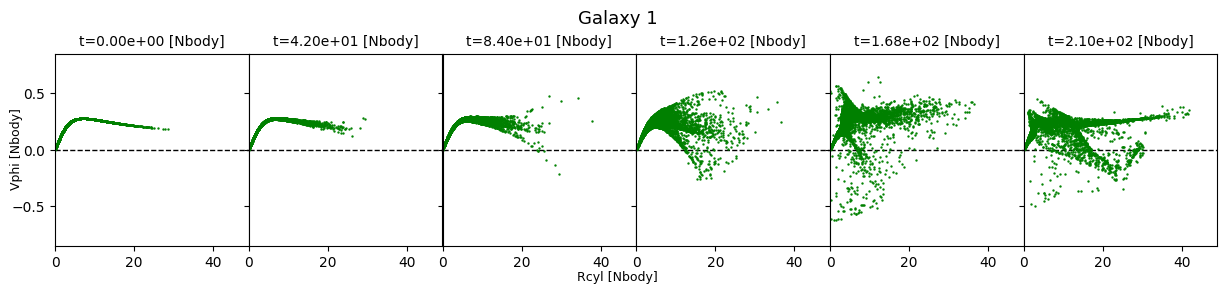

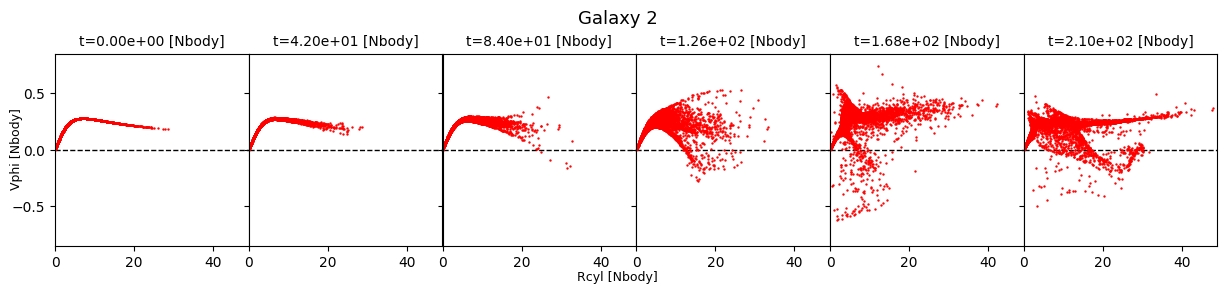

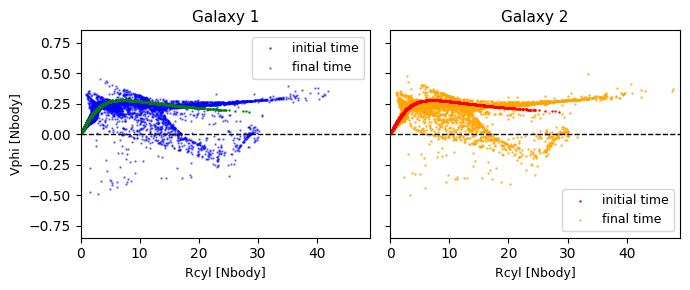

In [6]:
tstep=tf/nstep
t_arr=np.arange(ti+tstep, tf+tstep, tstep)
t_display=np.linspace(ti, tf, num=6, endpoint=True)
idx_display=np.linspace(0, nstep, num=6, endpoint=True)
idx_display=idx_display.astype(int)
key_pos_display=['pos_'+str(idx) for idx in idx_display]
key_vel_display=['vel_'+str(idx) for idx in idx_display]


### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vphi [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vphi1,vphi2=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R1,vphi1,s=0.5,c='g')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.85,0.85)
plt.savefig(path_plot+'3-2_1-gal1_vphi_vs_R_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vphi [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vphi1,vphi2=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R2,vphi2,s=0.5,c='r')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.85,0.85)
plt.savefig(path_plot+'3-2_2-gal2_vphi_vs_R_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING INITIAL AND FINAL
R1_i,R2_i,vphi1_i,vphi2_i=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos_display[0], vel_dict, key_vel_display[0])
R1_f,R2_f,vphi1_f,vphi2_f=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos_display[-1], vel_dict, key_vel_display[-1])

fig, axs = plt.subplots(1,2, figsize=(7,3), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(wspace=.001)
axs[0].scatter(R1_i,vphi1_i,s=0.5,c='g',label='initial time')
axs[0].scatter(R1_f,vphi1_f,s=0.5,c='b',alpha=0.5,label='final time',zorder=-5)
axs[0].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[0].legend(fontsize=9)
axs[0].set_ylabel('Vphi [Nbody]',fontsize=9)
axs[0].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[0].set_title('Galaxy 1',fontsize=11)
axs[0].set_xlim(0,49)
axs[0].set_ylim(-0.85,0.85)
axs[1].scatter(R2_i,vphi2_i,s=0.5,c='r',label='initial time')
axs[1].scatter(R2_f,vphi2_f,s=0.5,c='orange',alpha=0.8,label='final time',zorder=-5)
axs[1].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[1].legend(fontsize=9)
axs[1].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[1].set_title('Galaxy 2',fontsize=11)
axs[1].set_xlim(0,49)
plt.tight_layout()
plt.savefig(path_plot+'3-2_3-summary_vphi_vs_R.png', format="png",dpi=300)
plt.show()

*Result and discussion:*
1) $v_{phi}$ of the stars at larger $R_{cyl}$ start to change first due to the weaker gravitational forces from the host GCs at the positions. In contrast, the stars in the central regions near the galactic centers remain their $v_{phi}$ with almost no effect from the encounter due to their stronger gravitational forces. 
2) Firstly, most of the stars have slower $v_{phi}$, meaning that they slow down in the azimuthal direction until reaching negative $v_{phi}$, which tells us they have counter-rotation with respect to their own GCs.
3) The results of both galaxies are almost identical, which will be seen throughout this simulation because their ICs
are similar.

##### Radial velocity ($v_{R}$)

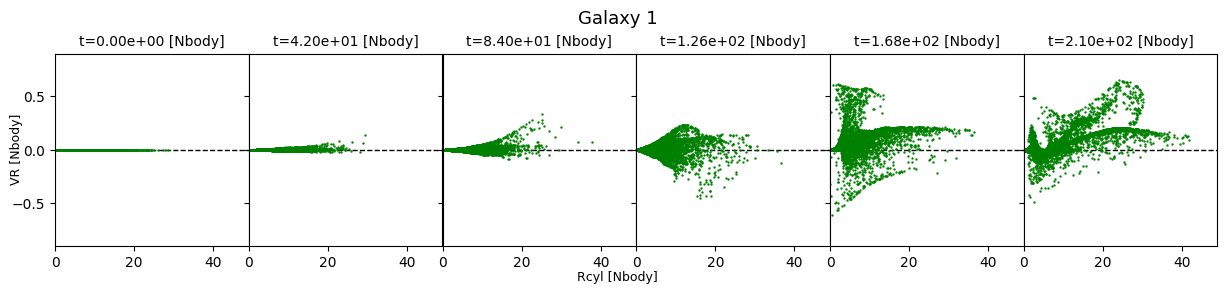

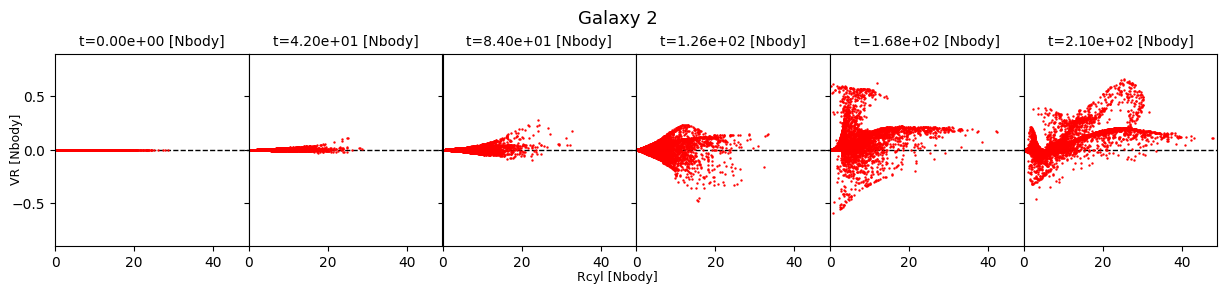

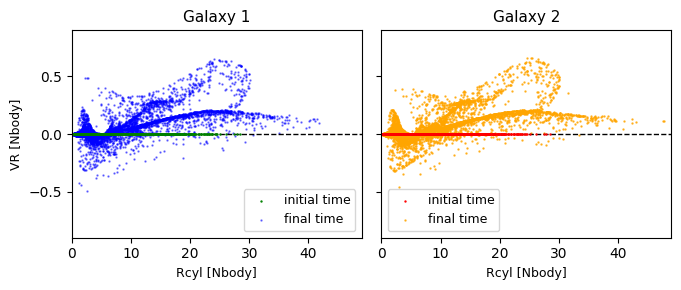

In [7]:
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'VR [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vR1,vR2=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R1,vR1,s=0.5,c='g')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.9,0.9)
plt.savefig(path_plot+'3-2_4-gal1_vR_vs_R_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'VR [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vR1,vR2=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R2,vR2,s=0.5,c='r')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.9,0.9)
plt.savefig(path_plot+'3-2_5-gal2_vR_vs_R_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING INITIAL AND FINAL
R1_i,R2_i,vR1_i,vR2_i=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos_display[0], vel_dict, key_vel_display[0])
R1_f,R2_f,vR1_f,vR2_f=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos_display[-1], vel_dict, key_vel_display[-1])

fig, axs = plt.subplots(1,2, figsize=(7,3), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(wspace=.001)
axs[0].scatter(R1_i,vR1_i,s=0.5,c='g',label='initial time')
axs[0].scatter(R1_f,vR1_f,s=0.5,c='b',alpha=0.5,label='final time',zorder=-5)
axs[0].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[0].legend(fontsize=9)
axs[0].set_ylabel('VR [Nbody]',fontsize=9)
axs[0].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[0].set_title('Galaxy 1',fontsize=11)
axs[0].set_xlim(0,49)
axs[0].set_ylim(-0.9,0.9)
axs[1].scatter(R2_i,vR2_i,s=0.5,c='r',label='initial time')
axs[1].scatter(R2_f,vR2_f,s=0.5,c='orange',alpha=0.8,label='final time',zorder=-5)
axs[1].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[1].legend(fontsize=9)
axs[1].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[1].set_title('Galaxy 2',fontsize=11)
axs[1].set_xlim(0,49)
plt.tight_layout()
plt.savefig(path_plot+'3-2_6-summary_vR_vs_R.png', format="png",dpi=300)
plt.show()

*Result and discussion:*
1) Similar to $v_{phi}$, $v_{R}$ of the stars at larger $R_{cyl}$ start to change first, then the stars at smaller $R_{cyl}$ do due to the different gravitational forces at their different positions. 
2) At the initial time, $v_{R}=0$, meaning that their stellar tracers maintain circular orbits, then after a certain time (at about t = 50 [Nbody]), their circular orbits start to be destroyed, which you can see both cases of stars moving inwards ($v_{R}<0$) and outwards ($v_{R}>0$) their GCs. In the final stage, the number of stars moving away from the GCs is much larger than those moving inwards, which indicates that the stellar tracers escape their host galaxies and/or galaxies' sizes expand, and/or these stellar currents create new tidal structures which will be seen more obviously in the structure production study.
3) We still see identical results for both galaxies due to the reasons mentioned earlier.

##### Vertical velocity ($v_{z}$)

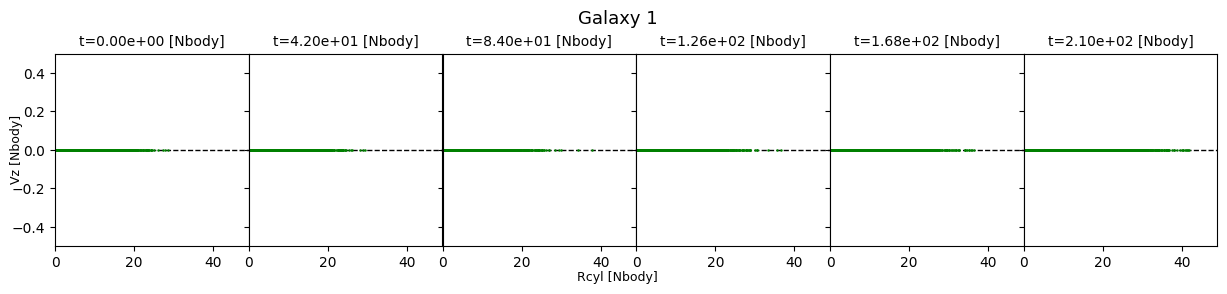

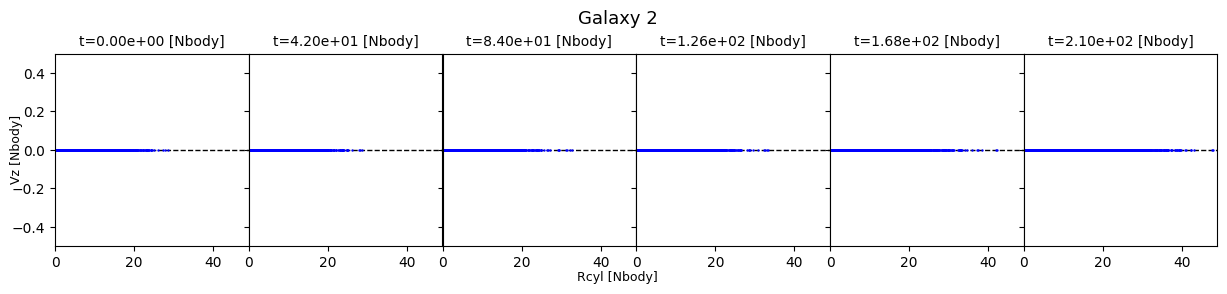

In [8]:
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vz [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vz1,vz2=H.compute_vz_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R1,vz1,s=0.6,c='g')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_ylim(-0.5,0.5)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-2_7-gal1_vz_vs_R_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vz [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vz1,vz2=H.compute_vz_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R2,vz2,s=0.5,c='b')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_ylim(-0.5,0.5)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-2_8-gal2_vz_vs_R_w_time.png', format="png",dpi=300)
plt.show()

*Result and discussion:* \
We found that $v_z$ of both galaxies' particles is constant at 0 across all evolving times, as expected. This is because of how we define the ICs that make stellar tracers confine on the xy plane of the disc.

#### -- 3.2.2 The disc surface profile evolving with time¶

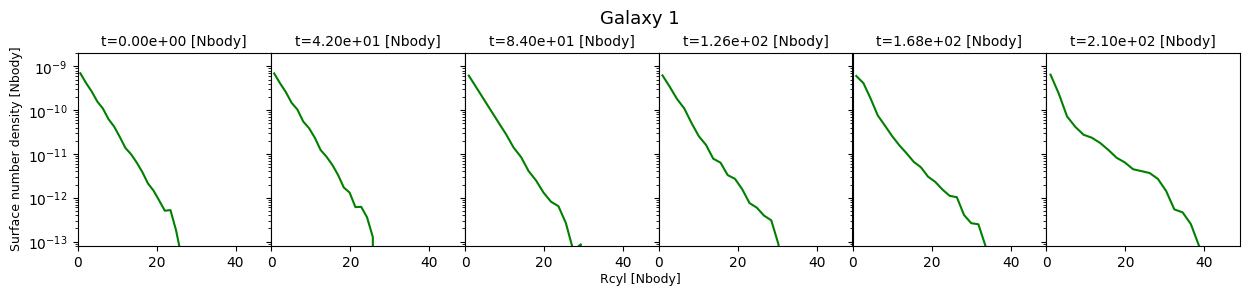

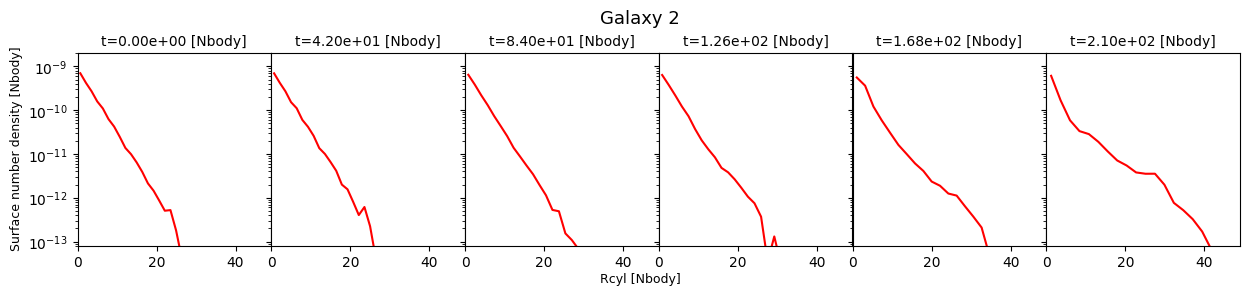

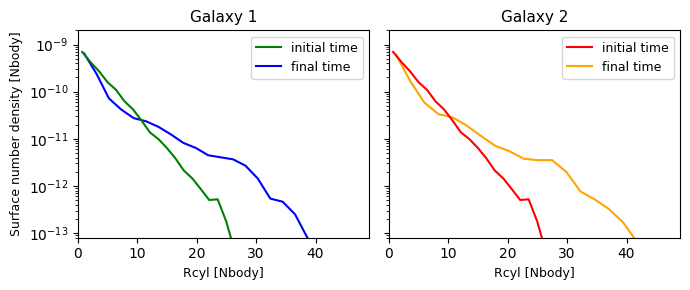

In [9]:
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'Surface number density [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    Rmid1,Rmid2,sigma1,sigma2=H.compute_surface_density_2galaxies(mass_arr, pos_dict, key_pos1, vel_dict, key_vel1, bins=20)
    axs[i].plot(Rmid1,sigma1,linewidth=1.5,c='g')
    axs[i].set_yscale('log')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(8e-14,2e-9)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-2_9-gal1_surface_profile_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'Surface number density [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    Rmid1,Rmid2,sigma1,sigma2=H.compute_surface_density_2galaxies(mass_arr, pos_dict, key_pos1, vel_dict, key_vel1, bins=20)
    axs[i].plot(Rmid2,sigma2,linewidth=1.5,c='r')
    axs[i].set_yscale('log')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(8e-14,2e-9)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-2_10-gal2_surface_profile_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING INITIAL AND FINAL
Rmid1_i,Rmid2_i,sigma1_i,sigma2_i=H.compute_surface_density_2galaxies(mass_arr, pos_dict,\
                                                                      key_pos_display[0], vel_dict, key_vel_display[0], bins=20)
Rmid1_f,Rmid2_f,sigma1_f,sigma2_f=H.compute_surface_density_2galaxies(mass_arr, pos_dict,\
                                                                      key_pos_display[-1], vel_dict, key_vel_display[-1], bins=20)
fig, axs = plt.subplots(1,2, figsize=(7,3), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(hspace = 1, wspace=.001)
axs[0].plot(Rmid1_i,sigma1_i,linewidth=1.5,c='g',label='initial time')
axs[0].plot(Rmid1_f,sigma1_f,linewidth=1.5,c='b',alpha=1.,label='final time',zorder=-5)
axs[0].legend(fontsize=9)
axs[0].set_ylabel('Surface number density [Nbody]',fontsize=9)
axs[0].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[0].set_title('Galaxy 1',fontsize=11)
axs[0].set_xlim(0,49)
axs[0].set_ylim(8e-14,2e-9)
axs[0].set_yscale('log')
axs[1].plot(Rmid2_i,sigma2_i,linewidth=1.5,c='r',label='initial time')
axs[1].plot(Rmid2_f,sigma2_f,linewidth=1.5,c='orange',alpha=1.,label='final time',zorder=-5)
axs[1].legend(fontsize=9)
axs[1].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[1].set_title('Galaxy 2',fontsize=11)
axs[1].set_xlim(0,49)
axs[1].set_yscale('log')
plt.tight_layout()
plt.savefig(path_plot+'3-2_11-summary_surface_profile.png', format="png",dpi=300)
plt.show()

*Result and discussion:* \
After a certain time, the stars in both galaxies start to disperse from the smaller to larger $R_{cyl}$, while the tracers in the central regions almost remain in their positions.

#### -- 3.2.3 The production of structures during the encounter

First, we plot the z positions of the stellar tracers in both galaxies to see if we need 3-dimensional plots of their disc geometry. As you can see from the plots below, the vertical components (z) positions are at 0 across all simulation times. So, we will plot the structure of interacting galaxies on the 2-dimensional xy plane only.

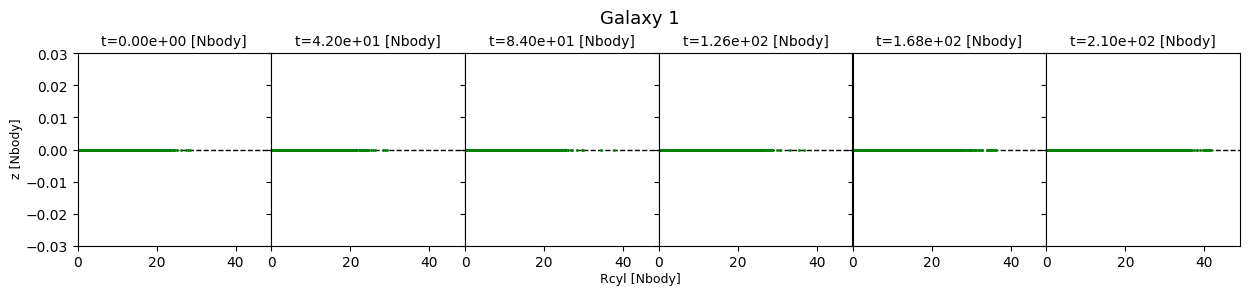

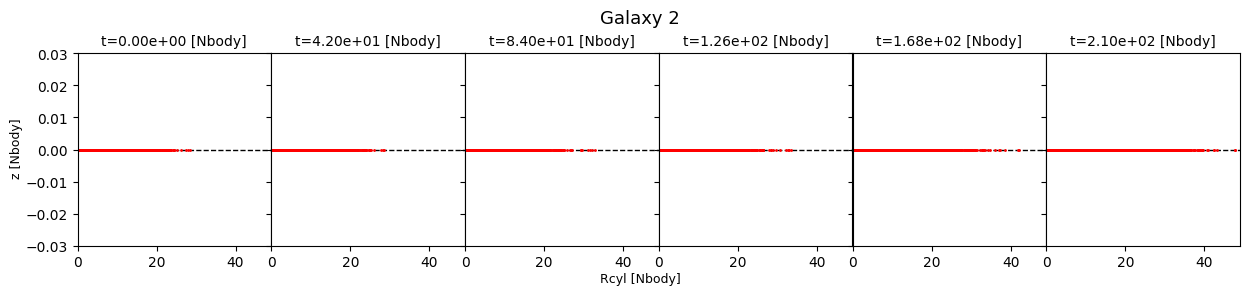

In [10]:
### PLOTTING z -> can see 2D xy plane
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True,sharex=True)
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'z [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    pos_arr1 = pos_dict[key_pos1][:Nall//2]
    x1=np.array([pos_arr1[j][0] for j in range(pos_arr1.shape[0])])-pos_arr1[0][0]
    y1=np.array([pos_arr1[j][1] for j in range(pos_arr1.shape[0])])-pos_arr1[0][1]
    z1=np.array([pos_arr1[j][2] for j in range(pos_arr1.shape[0])])-pos_arr1[0][2]
    axs[i].scatter(np.sqrt(x1*x1+y1*y1),z1,s=1,c='g')
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(-0.03,0.03)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-2_12-gal1_z_w_time.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True,sharex=True)
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'z [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    pos_arr2 = pos_dict[key_pos1][Nall//2:]
    x2=np.array([pos_arr2[j][0] for j in range(pos_arr2.shape[0])])-pos_arr2[0][0]
    y2=np.array([pos_arr2[j][1] for j in range(pos_arr2.shape[0])])-pos_arr2[0][1]
    z2=np.array([pos_arr2[j][2] for j in range(pos_arr2.shape[0])])-pos_arr2[0][2]
    axs[i].scatter(np.sqrt(x2*x2+y2*y2),z2,s=1,c='r')
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(-0.03,0.03)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-2_13-gal2_z_w_time.png', format="png",dpi=300)
plt.show()

/tmp/ipykernel_28/100694144.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, c1, l2, c2], labels=['Galaxy 1', 'GC 1', 'Galaxy2', 'GC 2'],loc="upper right")


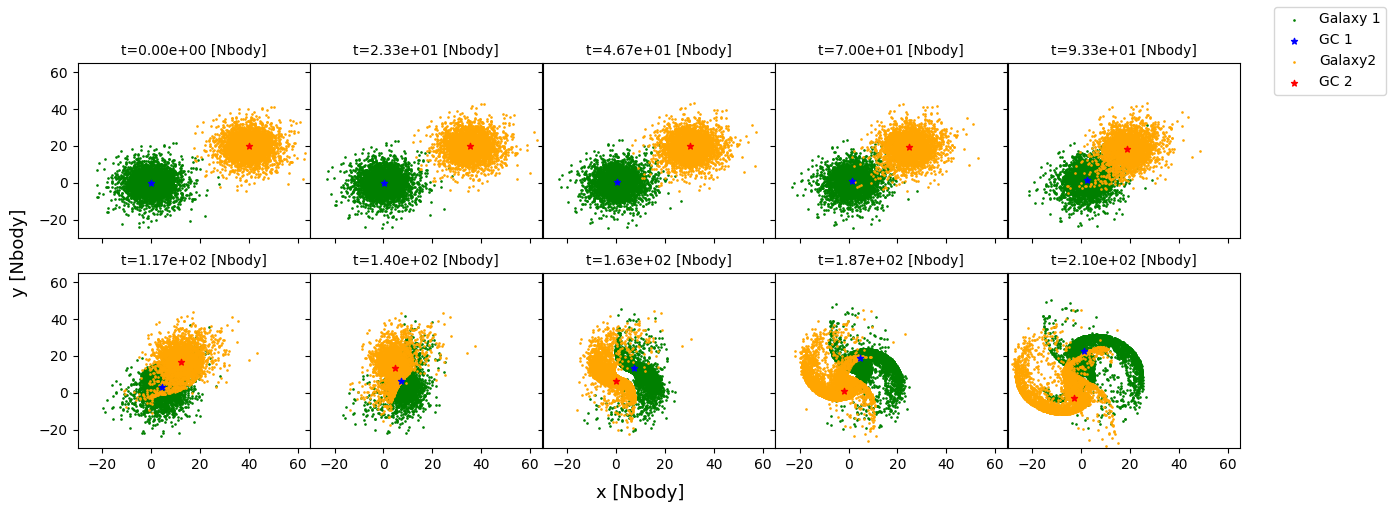

In [11]:
### PLOTTING 2D xy
t_arr=np.arange(ti+tstep, tf+tstep, tstep)
t_display=np.linspace(ti, tf, num=10, endpoint=True)
idx_display=np.linspace(0, nstep, num=10, endpoint=True)
idx_display=idx_display.astype(int)
key_pos_display=['pos_'+str(idx) for idx in idx_display]
key_vel_display=['vel_'+str(idx) for idx in idx_display]

fig, axs = plt.subplots(2,5, figsize=(15, 5), facecolor='w', edgecolor='k',sharey=True,sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.001)
fig.text(0.5, 0.01, 'x [Nbody]', ha='center',fontsize=13)
fig.text(0.08, 0.5, 'y [Nbody]', va='center', rotation='vertical',fontsize=13)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    #galaxy 1
    pos_arr1 = pos_dict[key_pos1][:Nall//2]
    x1=[pos_arr1[j][0] for j in range(pos_arr1.shape[0])]
    y1=[pos_arr1[j][1] for j in range(pos_arr1.shape[0])]
    z1=[pos_arr1[j][2] for j in range(pos_arr1.shape[0])]
    #galaxy 2
    pos_arr2 = pos_dict[key_pos1][Nall//2:]
    x2=[pos_arr2[j][0] for j in range(pos_arr2.shape[0])]
    y2=[pos_arr2[j][1] for j in range(pos_arr2.shape[0])]
    z2=[pos_arr2[j][2] for j in range(pos_arr2.shape[0])]
    l1=axs[i].scatter(x1,y1,s=0.8,c='g')
    c1=axs[i].scatter(x1[0],y1[0],marker='*',s=20,c='b',zorder=10)
    l2=axs[i].scatter(x2,y2,s=0.8,c='orange')
    c2=axs[i].scatter(x2[0],y2[0],marker='*',s=20,c='r',zorder=10)
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_xlim(-30, 65)
    axs[i].set_ylim(-30, 65)

fig.legend([l1, c1, l2, c2], labels=['Galaxy 1', 'GC 1', 'Galaxy2', 'GC 2'],loc="upper right") 
plt.savefig(path_plot+'3-2_14-xy_w_time.png', format="png",dpi=300)
plt.show()

<div style="text-align:center">
    <img src="./Final_project_data/Images_in_report/Antennae_Galaxies_reloaded.jpg" alt="Image Description" style="width:180px;"/>
    <img src="./Final_project_data/Images_in_report/Arp87full.jpg" alt="Image Description" style="width:350px;"/>
    <p style="text-align:center"><em>Figure 3: The realistic examples of interacting galaxies - Antennae galaxies (left) and Arp87 (right) (Credit: ESA/Hubble & NASA) </em></p>
</div>

*Result and discussion:* \
When the GCs of both galaxies pass by, the stellar tracers create the bridge linking the two galaxies and the tidal tails pointing away from them due to gravitational tides. These structures can be observed during actual galaxy encounters like in *Figure 3*.

### 3.3 The encounter of two counter-rotating galaxies

We are interested in studying the interaction of two galaxies with opposite rotation directions. We do the same experiment, like the encounter of two co-rotating galaxies, and find many similar results, which you will see later on. Thus, we try to emphasize the results that are different from those of the co-rotating case by not explaining the results similar to the co-rotating one in detail.

In [12]:
### Generate IC
Nall=int(1e4)
pos_com=[40,20,0]; vel_com=[-0.2,0,0]
particles=fic.ic_2galaxies_counter_rotating(Nall, pos_com, vel_com) 

### Simulation
ti=0.
tf=210.
nstep=int(1e3)
tstep=tf/nstep
mass_arr,pos_dict,vel_dict=H.sim_galaxy(particles,tf,nstep)

#### -- 3.3.1 The velocity curve evolving with time

##### Azimuthal velocity ($v_{\phi}$)

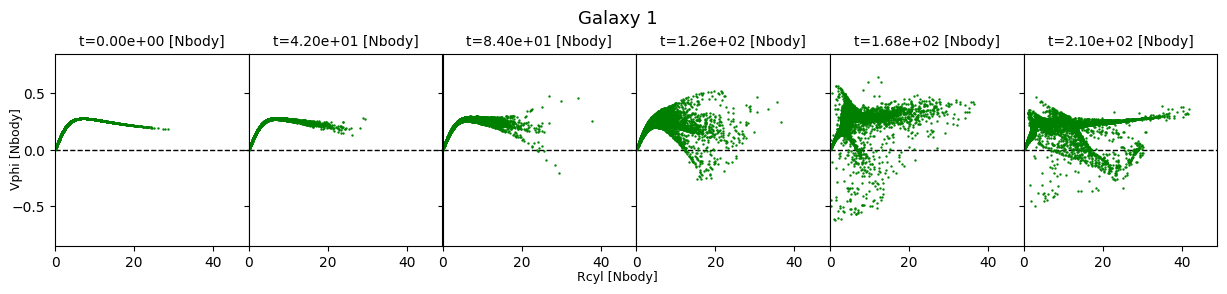

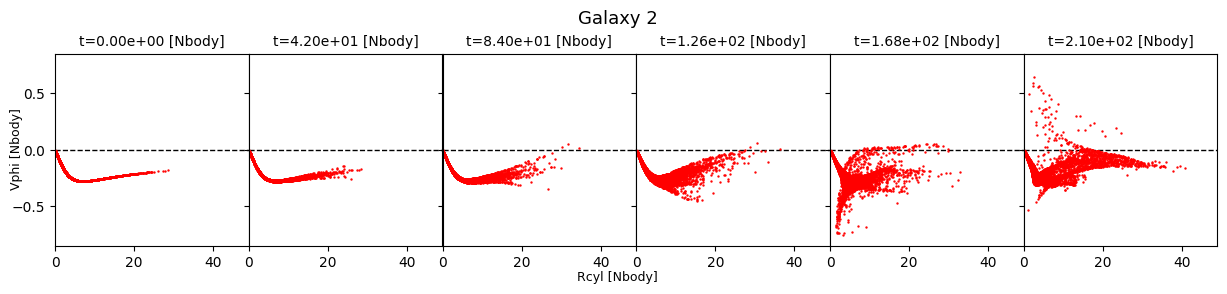

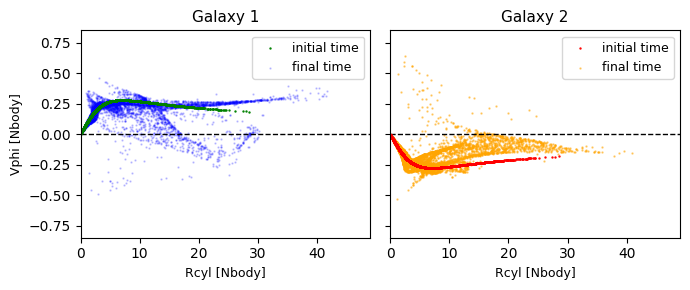

In [13]:
t_arr=np.arange(ti+tstep, tf+tstep, tstep)
t_display=np.linspace(ti, tf, num=6, endpoint=True)
idx_display=np.linspace(0, nstep, num=6, endpoint=True)
idx_display=idx_display.astype(int)
key_pos_display=['pos_'+str(idx) for idx in idx_display]
key_vel_display=['vel_'+str(idx) for idx in idx_display]


### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vphi [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vphi1,vphi2=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R1,vphi1,s=0.5,c='g')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.85,0.85)
plt.savefig(path_plot+'3-3_1-gal1_vphi_vs_R_w_time-counter.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vphi [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vphi1,vphi2=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R2,vphi2,s=0.5,c='r')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.85,0.85)
plt.savefig(path_plot+'3-3_2-gal2_vphi_vs_R_w_time-counter.png', format="png",dpi=300)
plt.show()

### PLOTTING INITIAL AND FINAL
R1_i,R2_i,vphi1_i,vphi2_i=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos_display[0], vel_dict, key_vel_display[0])
R1_f,R2_f,vphi1_f,vphi2_f=H.compute_vphi_vs_R_simple_2galaxies(pos_dict, key_pos_display[-1], vel_dict, key_vel_display[-1])

fig, axs = plt.subplots(1,2, figsize=(7,3), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(wspace=.001)
axs[0].scatter(R1_i,vphi1_i,s=0.5,c='g',label='initial time')
axs[0].scatter(R1_f,vphi1_f,s=0.5,c='b',alpha=0.2,label='final time',zorder=-5)
axs[0].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[0].legend(fontsize=9)
axs[0].set_ylabel('Vphi [Nbody]',fontsize=9)
axs[0].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[0].set_title('Galaxy 1',fontsize=11)
axs[0].set_xlim(0,49)
axs[0].set_ylim(-0.85,0.85)
axs[1].scatter(R2_i,vphi2_i,s=0.5,c='r',label='initial time')
axs[1].scatter(R2_f,vphi2_f,s=0.5,c='orange',alpha=0.5,label='final time',zorder=-5)
axs[1].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[1].legend(fontsize=9)
axs[1].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[1].set_title('Galaxy 2',fontsize=11)
axs[1].set_xlim(0,49)
plt.tight_layout()
plt.savefig(path_plot+'3-3_3-summary_vphi_vs_R-counter.png', format="png",dpi=300)
plt.show()

*Result and discussion:* 
1) Similar to the co-rotating case, $v_{phi}$ of the stars at larger $R_{cyl}$ start to change first.
2) If we consider that *Galaxy 1* particles have positive $v_{phi}$ while *Galaxy 2* particles have negative $v_{phi}$, in the end, some stars are captured by the other galaxy when their $v_{phi}$ signs change.
3) Unlike the co-rotating case, we change the IC of *Galaxy 2*; thus, the results of both galaxies are no longer identical (in terms of the magnitude of the $v_{phi}$).

##### Radial velocity ($v_{R}$)

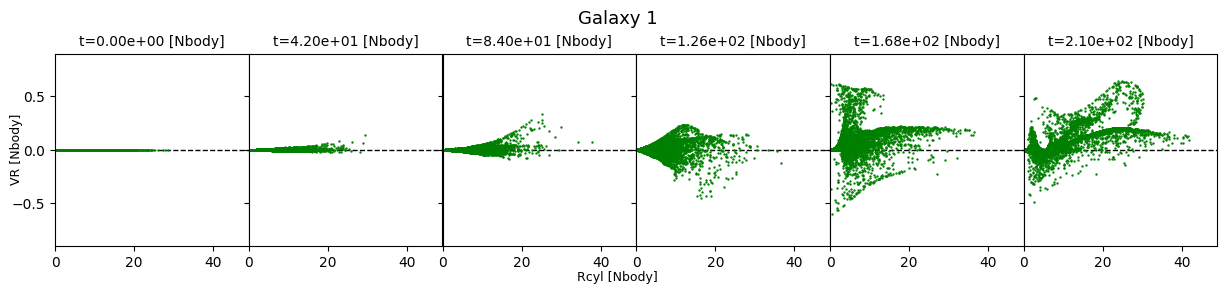

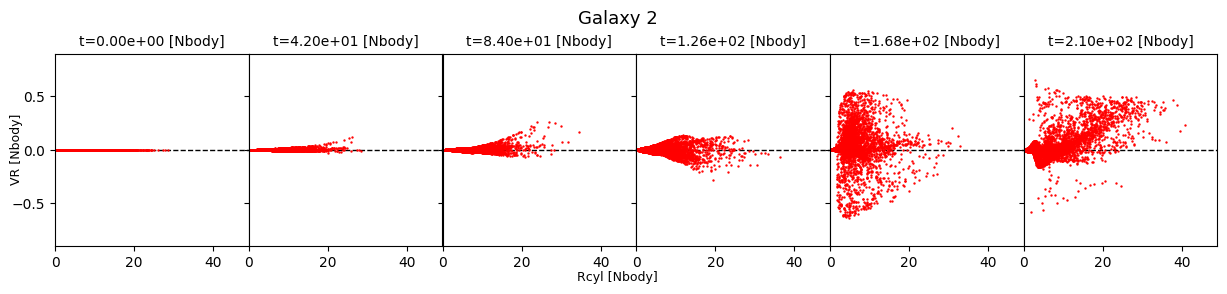

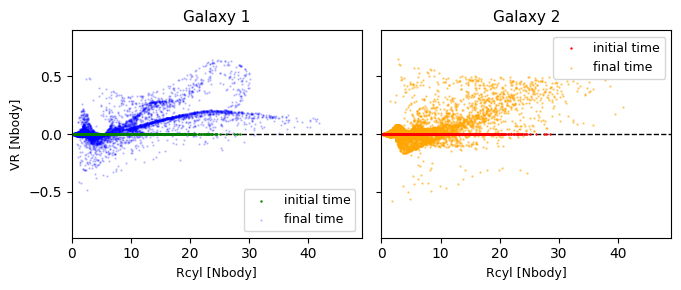

In [15]:
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'VR [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vR1,vR2=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R1,vR1,s=0.5,c='g')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.9,0.9)
plt.savefig(path_plot+'3-3_4-gal1_vR_vs_R_w_time-counter.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'VR [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vR1,vR2=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R2,vR2,s=0.5,c='r')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_xlim(0,49)
    axs[i].set_ylim(-0.9,0.9)
plt.savefig(path_plot+'3-3_5-gal2_vR_vs_R_w_time-counter.png', format="png",dpi=300)  
plt.show()

### PLOTTING INITIAL AND FINAL
R1_i,R2_i,vR1_i,vR2_i=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos_display[0], vel_dict, key_vel_display[0])
R1_f,R2_f,vR1_f,vR2_f=H.compute_vR_vs_R_simple_2galaxies(pos_dict, key_pos_display[-1], vel_dict, key_vel_display[-1])

fig, axs = plt.subplots(1,2, figsize=(7,3), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(wspace=.001)
axs[0].scatter(R1_i,vR1_i,s=0.5,c='g',label='initial time')
axs[0].scatter(R1_f,vR1_f,s=0.5,c='b',alpha=0.2,label='final time',zorder=-5)
axs[0].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[0].legend(fontsize=9)
axs[0].set_ylabel('VR [Nbody]',fontsize=9)
axs[0].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[0].set_title('Galaxy 1',fontsize=11)
axs[0].set_xlim(0,49)
axs[0].set_ylim(-0.9,0.9)
axs[1].scatter(R2_i,vR2_i,s=0.5,c='r',label='initial time')
axs[1].scatter(R2_f,vR2_f,s=0.5,c='orange',alpha=0.5,label='final time',zorder=-5)
axs[1].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
axs[1].legend(fontsize=9)
axs[1].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[1].set_title('Galaxy 2',fontsize=11)
axs[1].set_xlim(0,49)
plt.tight_layout()
plt.savefig(path_plot+'3-3_6-summary_vR_vs_R-counter.png', format="png",dpi=300) 
plt.show()

*Result and discussion:* \
You can see both cases of stars moving inwards ($v_{R}<0$) and outwards ($v_{R}>0$) their GCs like in the previous simulation. However, the results of both galaxies are different. *Galaxy 2* has random $v_{R}$ change, while *Galaxy 1* has a pattern of $v_{R}$ change, which we cannot conclude the results for now but will understand better in the structure production study.

##### Vertical velocity ($v_{z}$)

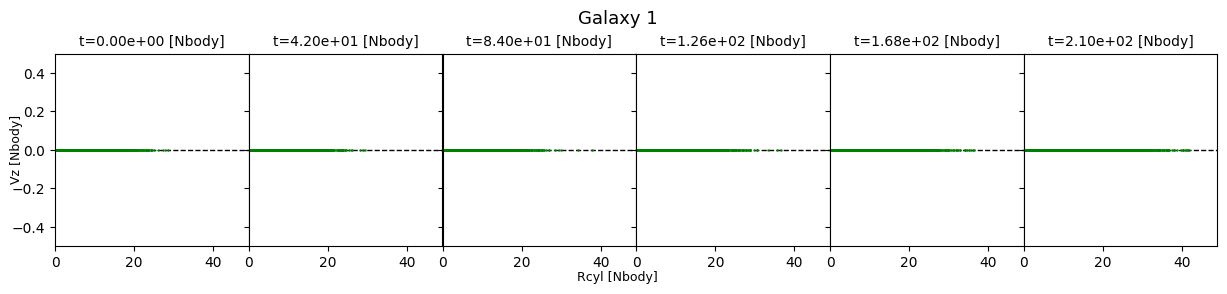

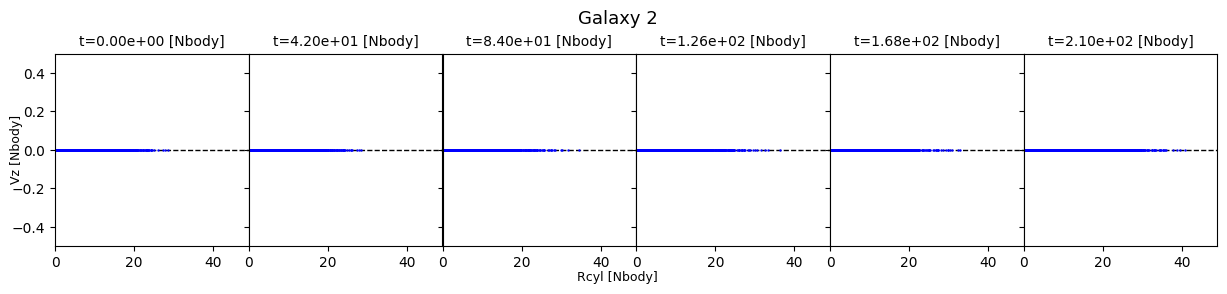

In [16]:
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vz [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vz1,vz2=H.compute_vz_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R1,vz1,s=0.5,c='g')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_ylim(-0.5,0.5)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-3_7-gal1_vz_vs_R_w_time-counter.png', format="png",dpi=300)  
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.03, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.095, 0.5, 'Vz [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    R1,R2,vz1,vz2=H.compute_vz_vs_R_simple_2galaxies(pos_dict, key_pos1, vel_dict, key_vel1)
    axs[i].scatter(R2,vz2,s=0.5,c='b')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_ylim(-0.5,0.5)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-3_8-gal2_vz_vs_R_w_time-counter.png', format="png",dpi=300) 
plt.show()

*Result and discussion:* \
Same as the co-rotating case where $v_z$ remains at 0

#### -- 3.3.2 The disc surface profile evolving with time

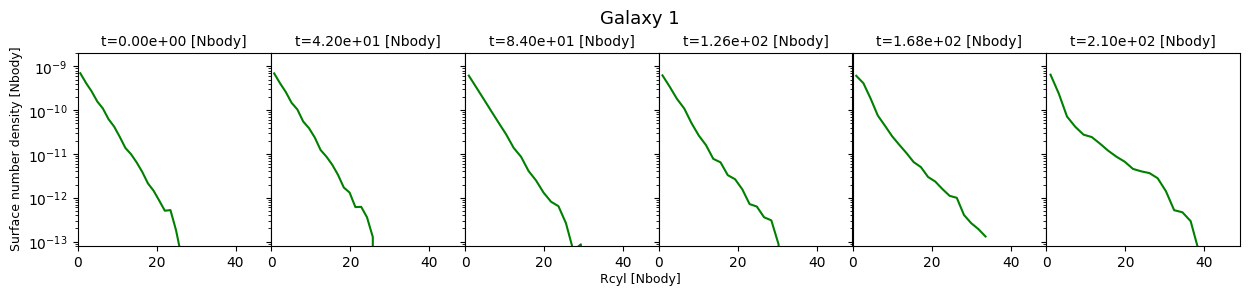

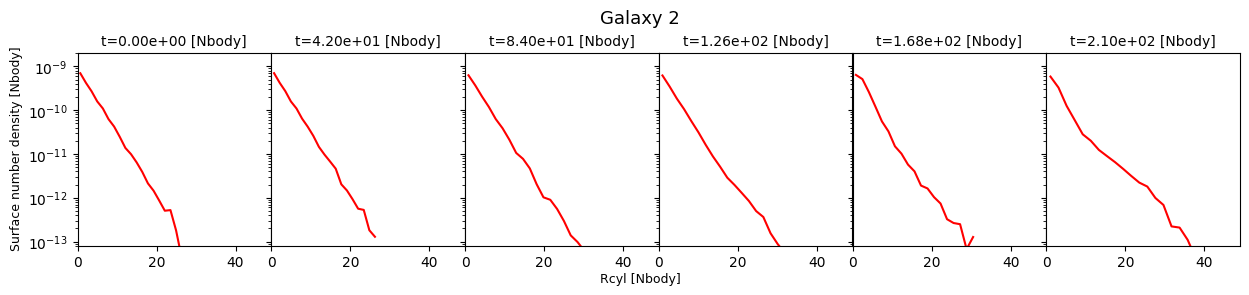

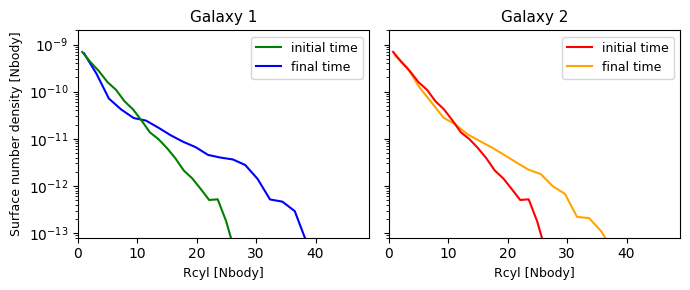

In [17]:
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
#fig.suptitle('Galaxy 1', fontsize=16)
fig.subplots_adjust(hspace = 1, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'Surface number density [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    Rmid1,Rmid2,sigma1,sigma2=H.compute_surface_density_2galaxies(mass_arr, pos_dict, key_pos1, vel_dict, key_vel1, bins=20)
    axs[i].plot(Rmid1,sigma1,linewidth=1.5,c='g')
    axs[i].set_yscale('log')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(8e-14,2e-9)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-3_9-gal1_surface_profile_w_time-counter.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True)#,sharey=True
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'Surface number density [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    Rmid1,Rmid2,sigma1,sigma2=H.compute_surface_density_2galaxies(mass_arr, pos_dict, key_pos1, vel_dict, key_vel1, bins=20)
    axs[i].plot(Rmid2,sigma2,linewidth=1.5,c='r')
    axs[i].set_yscale('log')
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(8e-14,2e-9)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-3_10-gal2_surface_profile_w_time-counter.png', format="png",dpi=300)  
plt.show()

### PLOTTING INITIAL AND FINAL
Rmid1_i,Rmid2_i,sigma1_i,sigma2_i=H.compute_surface_density_2galaxies(mass_arr, pos_dict,\
                                                                      key_pos_display[0], vel_dict, key_vel_display[0], bins=20)
Rmid1_f,Rmid2_f,sigma1_f,sigma2_f=H.compute_surface_density_2galaxies(mass_arr, pos_dict,\
                                                                      key_pos_display[-1], vel_dict, key_vel_display[-1], bins=20)
fig, axs = plt.subplots(1,2, figsize=(7,3), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(hspace = 1, wspace=.001)
axs[0].plot(Rmid1_i,sigma1_i,linewidth=1.5,c='g',label='initial time')
axs[0].plot(Rmid1_f,sigma1_f,linewidth=1.5,c='b',alpha=1.,label='final time',zorder=-5)
axs[0].legend(fontsize=9)
axs[0].set_ylabel('Surface number density [Nbody]',fontsize=9)
axs[0].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[0].set_title('Galaxy 1',fontsize=11)
axs[0].set_xlim(0,49)
axs[0].set_ylim(8e-14,2e-9)
axs[0].set_yscale('log')
axs[1].plot(Rmid2_i,sigma2_i,linewidth=1.5,c='r',label='initial time')
axs[1].plot(Rmid2_f,sigma2_f,linewidth=1.5,c='orange',alpha=1.,label='final time',zorder=-5)
axs[1].legend(fontsize=9)
axs[1].set_xlabel('Rcyl [Nbody]',fontsize=9)
axs[1].set_title('Galaxy 2',fontsize=11)
axs[1].set_xlim(0,49)
axs[1].set_yscale('log')
plt.tight_layout()
plt.savefig(path_plot+'3-3_11-summary_surface_profile-counter.png', format="png",dpi=300) 
plt.show()

*Result and discussion:* 
1) Similar to the co-rotating simulation, the stars in both galaxies disperse from smaller to larger $R_{cyl}$
2) Different from the previous simulation, in this case, *Galaxy 2* particles remain more compact than *Galaxy 1* ones since the stars in the inner region do not disperse that much. You will see better in the structure production study.

#### -- 3.3.3 The production of structures during the encounter

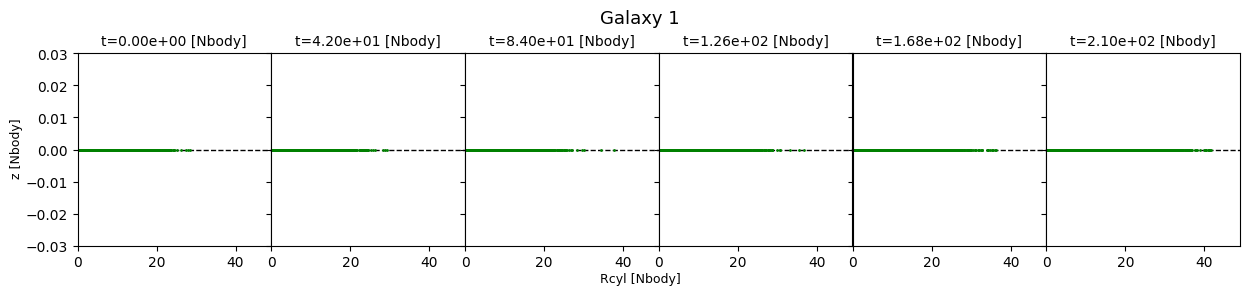

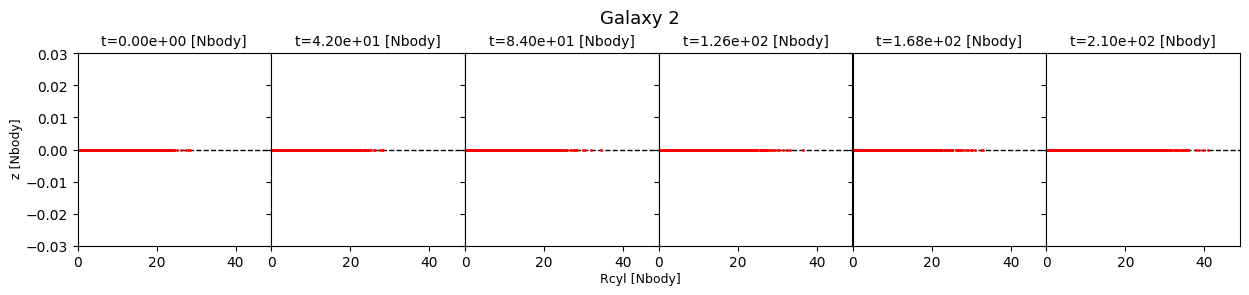

In [18]:
### PLOTTING z -> can see 2D xy plane
### PLOTTING GALAXY 1
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True,sharex=True)
fig.text(0.5, 1, 'Galaxy 1', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'z [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    pos_arr1 = pos_dict[key_pos1][:Nall//2]
    x1=np.array([pos_arr1[j][0] for j in range(pos_arr1.shape[0])])-pos_arr1[0][0]
    y1=np.array([pos_arr1[j][1] for j in range(pos_arr1.shape[0])])-pos_arr1[0][1]
    z1=np.array([pos_arr1[j][2] for j in range(pos_arr1.shape[0])])-pos_arr1[0][2]
    axs[i].scatter(np.sqrt(x1*x1+y1*y1),z1,s=1,c='g')
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(-0.03,0.03)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-3_12-gal1_z_w_time-counter.png', format="png",dpi=300)
plt.show()

### PLOTTING GALAXY 2
fig, axs = plt.subplots(1,6, figsize=(15, 2.5), facecolor='w', edgecolor='k',sharey=True,sharex=True)
fig.text(0.5, 1, 'Galaxy 2', ha='center',fontsize=13)
fig.subplots_adjust(hspace =3, wspace=.001)
fig.text(0.5, -0.035, 'Rcyl [Nbody]', ha='center',fontsize=9)
fig.text(0.08, 0.5, 'z [Nbody]', va='center', rotation='vertical',fontsize=9)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    pos_arr2 = pos_dict[key_pos1][Nall//2:]
    x2=np.array([pos_arr2[j][0] for j in range(pos_arr2.shape[0])])-pos_arr2[0][0]
    y2=np.array([pos_arr2[j][1] for j in range(pos_arr2.shape[0])])-pos_arr2[0][1]
    z2=np.array([pos_arr2[j][2] for j in range(pos_arr2.shape[0])])-pos_arr2[0][2]
    axs[i].scatter(np.sqrt(x2*x2+y2*y2),z2,s=1,c='r')
    axs[i].axhline(y=0,color='k',linestyle='--',zorder=-5,linewidth=1)
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_ylim(-0.03,0.03)
    axs[i].set_xlim(0,49)
plt.savefig(path_plot+'3-3_13-gal2_z_w_time-counter.png', format="png",dpi=300)
plt.show()

/tmp/ipykernel_28/2835315003.py:35: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, c1, l2, c2], labels=['Galaxy 1', 'GC 1', 'Galaxy2', 'GC 2'],loc="upper right")


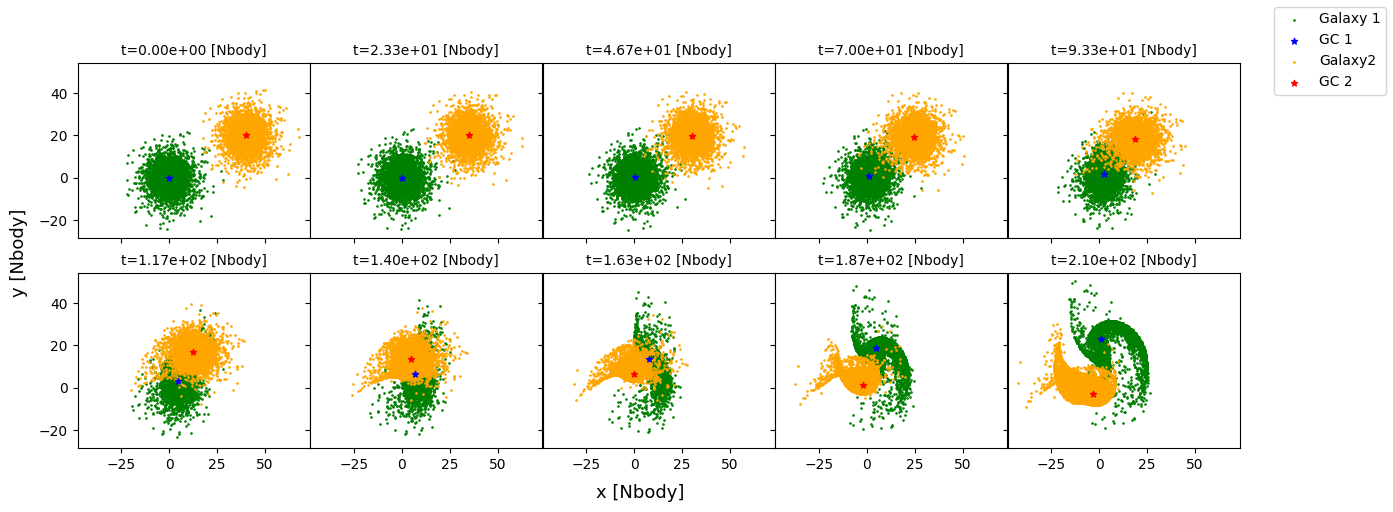

In [19]:
### PLOTTING 2D xy
t_arr=np.arange(ti+tstep, tf+tstep, tstep)
t_display=np.linspace(ti, tf, num=10, endpoint=True)
idx_display=np.linspace(0, nstep, num=10, endpoint=True)
idx_display=idx_display.astype(int)
key_pos_display=['pos_'+str(idx) for idx in idx_display]
key_vel_display=['vel_'+str(idx) for idx in idx_display]

fig, axs = plt.subplots(2,5, figsize=(15, 5), facecolor='w', edgecolor='k',sharey=True,sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.001)
fig.text(0.5, 0.01, 'x [Nbody]', ha='center',fontsize=13)
fig.text(0.08, 0.5, 'y [Nbody]', va='center', rotation='vertical',fontsize=13)
axs = axs.ravel()
for i in range(len(idx_display)):
    t=t_display[i]
    key_pos1=key_pos_display[i]
    key_vel1=key_vel_display[i]
    #galaxy 1
    pos_arr1 = pos_dict[key_pos1][:Nall//2]
    x1=[pos_arr1[j][0] for j in range(pos_arr1.shape[0])]
    y1=[pos_arr1[j][1] for j in range(pos_arr1.shape[0])]
    z1=[pos_arr1[j][2] for j in range(pos_arr1.shape[0])]
    #galaxy 2
    pos_arr2 = pos_dict[key_pos1][Nall//2:]
    x2=[pos_arr2[j][0] for j in range(pos_arr2.shape[0])]
    y2=[pos_arr2[j][1] for j in range(pos_arr2.shape[0])]
    z2=[pos_arr2[j][2] for j in range(pos_arr2.shape[0])]
    l1=axs[i].scatter(x1,y1,s=0.8,c='g')
    c1=axs[i].scatter(x1[0],y1[0],marker='*',s=20,c='b',zorder=10)
    l2=axs[i].scatter(x2,y2,s=0.8,c='orange')
    c2=axs[i].scatter(x2[0],y2[0],marker='*',s=20,c='r',zorder=10)
    axs[i].set_title('t='+"{:.2e}".format(t)+' [Nbody]',fontsize=10)
    axs[i].set_xlim

fig.legend([l1, c1, l2, c2], labels=['Galaxy 1', 'GC 1', 'Galaxy2', 'GC 2'],loc="upper right") 
plt.savefig(path_plot+'3-3_14-xy_w_time-counter.png', format="png",dpi=300)
plt.show()

*Result and discussion:* 
1) Similar to the previous simulation, this encounter creates the bridge and tidal tails.
2) However, the tidal bridge is not obvious to see and takes more time to create due to the opposite direction of rotation, making the interacting galaxies harder to interact with or combine.
3) The clear tidal tails of *Galaxy 1* explain the patterned $v_{R}$ change in the previous subsection.
4) *Galaxy 2* seems more compact than *Galaxy 1*, which has the clear tidal tails. Thus, the surface density profile of *Galaxy 2* is more compact with fewer stars from its inner region dispersed to its outer region.

-------------------------------------------------------------------------------------------------------------------------------------------

## 4 Conclusion and possible future work

In this work, we used stars as tracers and the simple model of disc galaxies to study the gravitational effect on two colliding disc galaxies. According to the results, this model is good enough to reproduce the structures observed in actual interacting systems like *Antennae galaxies* and *Arp87*. Therefore, we found that gravitational tides are the major cause of the creation of tidal structures (e.g., tails and bridges) in interacting galaxies.

In the co-rotating encounter, both galaxies have almost identical results due to their similar ICs, while in the counter-rotating case, we changed the velocity IC of *Galaxy 2*, making their results different, as you can see in section 3.3.

According to all the results, the stellar tracers' properties (i.e., positions and velocities) barely change at the beginning. Then, in the late stages, they change rapidly because gravitational potential begins changing quickly, making stellar orbits lose their prior traces and change rapidly. This process is called *violent relaxation* (if we understand correctly).

Another interesting remark is that we can clearly see the tidal structures in this study since we are simulating the interacting discs, which have well-organized motions. Thus, gravitational tides have a similar impact on stars, making the effect much more visible. Unlike elliptical galaxies, whose stars were initially distributed randomly in phase space, the net tidal effect does not make an obvious change globally. So, it is difficult to see such tidal structures in isotropic systems.

In my opinion, we can improve this study to other more complicated and realistic cases. Here is the list of possible future work I can think of:
1) In reality, galaxy mergers can trigger star formation by collecting and compressing vast clouds of hydrogen and eventually triggering a series of gravitational collapses. If we study gases as tracers, we can see the gas density distribution overlapping on the positions of the interacting galaxies. Thus, we will have an idea of which locations in the systems have more chance of having star formation. However, due to the limitation of computation resources, we cannot use individual gas particles in the whole system as tracers. We might need to use other more suitable tracers like gas clouds or limit the galactic regions to study. Furthermore, the interaction of gas-gas particles must be included in this model.
2) Our MW and M31 will collide in about 4.5 Gyr, and it is believed that they will merge and turn into a giant elliptical galaxy. If we would like to prove this statement, we need a more specific and realistic model for this study. For example, the ICs of the two galaxies must be adjusted according to their observations; the structures of galaxies (e.g. SMBH, spiral arms, DM halo), the appropriate inclination and positions of the galactic tracers, their appropriate velocity distribution from spectroscopic studies, and the appropriate potentials of different structures (i.e., inner spheroid, stellar disc, and DM halo) which are commonly studied for MW (e.g. Johnston et al. (1995) and Bovy (2015)) as provided in *Lecture 3*.

-------------------------------------------------------------------------------------------------------------------------------------------

## 5 Reference

- Lectures of this course
- Lecture notes of the course SCP9086385 GALACTIC DYNAMICS (Prof. Corsini)
- Pierre-Alain Duc and Florent Renaud. “Tides in Colliding Galaxies”. In: Lecture Notes in Physics, Berlin Springer Verlag. Ed. by Jean Souchay, St ́ephane Mathis, and Tadashi Tokieda. Vol. 861. 2013, p. 327. doi: 10.1007/978-3-642-32961-6_9.


-------------------------------------------------------------------------------------------------------------------------------------------